### Defining the functions from HA3:

In [1]:
def eps_greedy_policy(q_values, eps):
    '''
    Creates an epsilon-greedy policy
    :param q_values: set of Q-values of shape (num actions,)
    :param eps: probability of taking a uniform random action 
    :return: policy of shape (num actions,)
    '''
    # YOUR CODE HERE
    policy = np.zeros(q_values.shape) # Pre-defining output array
    optimal_policy = q_values.argmax()
    for i in range(len(policy)):
        if i == optimal_policy:
            policy[i] = 1 - (len(q_values) - 1)*eps/len(q_values)
        else:
            policy[i] = eps/len(q_values)
    return policy
    

In [2]:
def calc_q_and_take_action(ddqn, state, eps):
    '''
    Calculate Q-values for current state, and take an action according to an epsilon-greedy policy.
    Inputs:
        ddqn   - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        state  - Current state. Numpy array, shape (1, num_states).
        eps    - Exploration parameter.
    Returns:
        q_online_curr   - Q(s,a) for current state s. Numpy array, shape (1, num_actions) or  (num_actions,).
        curr_action     - Selected action (0 to 4, i.e. no change, up, down, steer left, steer right), sampled from epsilon-greedy policy. Integer.
    '''
    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input, and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).

    # YOUR CODE HERE
    q_online_curr = ddqn.online_model(torch.Tensor(state).to(device))
    q_online_curr = q_online_curr.cpu().detach().numpy() # Conversion to numpy array
    
    q_online_curr_flat = q_online_curr.flatten()
    policy = eps_greedy_policy(q_online_curr_flat, eps)
    curr_action = np.random.choice(np.arange(4, dtype=np.int32), p = policy)
    
    return q_online_curr, curr_action

In [3]:
def calculate_q_targets(q1_batch, q2_batch, r_batch, nonterminal_batch, gamma=.99):
    '''
    Calculates the Q target used for the loss
    : param q1_batch: Batch of Q(s', a) from online network. FloatTensor, shape (N, num actions)
    : param q2_batch: Batch of Q(s', a) from target network. FloatTensor, shape (N, num actions)
    : param r_batch: Batch of rewards. FloatTensor, shape (N,)
    : param nonterminal_batch: Batch of booleans, with False elements if state s' is terminal and True otherwise. BoolTensor, shape (N,)
    : param gamma: Discount factor, float.
    : return: Q target. FloatTensor, shape (N,)
    '''
    # YOUR CODE HERE
    _, action_batch = q1_batch.max(1)
    N = q1_batch.shape[0]
    nonterminal_batch_float = nonterminal_batch.float() # From boolean to float format
    Y = r_batch + torch.mul(nonterminal_batch_float, gamma*q2_batch[np.arange(N), action_batch]) # Element-wise operations
    return Y

In [4]:
def sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma):
    '''
    Sample mini-batch from replay buffer, and compute the mini-batch loss
    Inputs:
        ddqn          - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        replay_buffer - Replay buffer object (from which smaples will be drawn)
        batch_size    - Batch size
        gamma         - Discount factor
    Returns:
        Mini-batch loss, on which .backward() will be called to compute gradient.
    '''
    # Sample a minibatch of transitions from replay buffer
    curr_state, curr_action, reward, next_state, nonterminal = replay_buffer.sample_minibatch(batch_size)

    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input, and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).

    # YOUR CODE HERE
    q_online_curr = ddqn.online_model(curr_state) 
    q_online_next = ddqn.online_model(next_state)
    with torch.no_grad():
        q_offline_next = ddqn.offline_model(next_state)

    q_target = calculate_q_targets(q_online_next, q_offline_next, reward, nonterminal, gamma=gamma)
    loss = ddqn.calc_loss(q_online_curr, q_target, curr_action)

    return loss

In [5]:
def epsilon_decay_fun(step, decay, eps_end):
    return eps_end + (1 - eps_end)*np.exp(-decay*step);

In [6]:
import torch
import dqn_model
import numpy as np
import gym
from collections import namedtuple
from dqn_model import DoubleQLearningModel, ExperienceReplay

In [7]:
# CPU should be enough, but feel free to play around with this if you want to.
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, max_steps_per_episode, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    eps = 1
    eps_end = .1 
    #eps_decay = 1e-4
    eps_decay = 3e-4
    tau = 1000
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    for i in range(num_episodes):
        state = env.reset() # Initial state
        state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        for _ in range(max_steps_per_episode):
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1

            # Take one step in environment. No need to compute gradients,
            # we will just store transition to replay buffer, and later sample a whole batch
            # from the replay buffer to actually take a gradient step.
            q_online_curr, curr_action = calc_q_and_take_action(ddqn, state, eps)
            q_buffer.append(q_online_curr)
            new_state, reward, finish_episode, _ = env.step(curr_action) # take one step in the evironment
            new_state = new_state[None,:]
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            nonterminal_to_buffer = not finish_episode or steps == max_steps_per_episode
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                loss = sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma)
                ddqn.optimizer.zero_grad()
                loss.backward()
                ddqn.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    ddqn.update_target_network()
            if finish_episode:
                break
                
        eps = max(eps - eps_decay, eps_end) # decrease epsilon
        #eps = epsilon_decay_fun(i, eps_decay, eps_end) # decrease epsilon
        R_buffer.append(ep_reward)
        
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1]) if i > 0 else R_avg.append(R_buffer[i])

        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}'.format(i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer))))
        
        # If running average > 195 (close to 200), the task is considered solved
        if R_avg[-1] >= 20:
            env.close()
            return R_buffer, R_avg
    env.close()
    return R_buffer, R_avg

### Training:

In [8]:
# Create the environment
#env = gym.make("CartPole-v0")
from trailer_reverse_gym_environment import CarTrailerParkingRevEnv
env = CarTrailerParkingRevEnv()

# Enable visualization? Does not work in all environments.
enable_visualization = False

# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
num_episodes = 15000
max_steps_per_episode = 1000
batch_size = 128
gamma = .94
learning_rate = 1e-4

# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)

# Create replay buffer, where experience in form of tuples <s,a,r,s',t>, gathered from the environment is stored 
# for training
replay_buffer = ExperienceReplay(device, num_states)

# Train
R, R_avg = train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, max_steps_per_episode, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)
# close window
if enable_visualization:
    env.close()

In [22]:
env.close()

### Visualization of results with greedy policy:

In [21]:
import time
num_episodes = 10
env = CarTrailerParkingRevEnv()

nr_of_success = 0
if True:
    for i in range(num_episodes):
            state = env.reset() #reset to initial state
            terminal = False # reset terminal flag
            while not terminal:
                env.render()
                with torch.no_grad():
                    q_values = ddqn.online_model(torch.tensor(state, dtype=torch.float, device=device)).cpu().numpy()
                policy = eps_greedy_policy(q_values.squeeze(), .1) # greedy policy
                action = np.random.choice(num_actions, p=policy)
                state, reward, terminal, _ = env.step(action) # take one step in the evironment
                state = state[None,:]
                time.sleep(0.1)
            if reward == 20:
                nr_of_success += 1
    # close window
    env.close();
print('Success rate:', nr_of_success/num_episodes)

KeyboardInterrupt: 

### Plot of the average return:

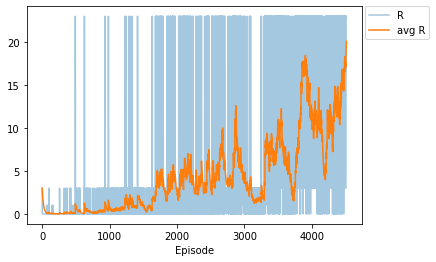

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

rewards = plt.plot(R, alpha=.4, label='R')
avg_rewards = plt.plot(R_avg,label='avg R')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episode')
plt.show()

In [13]:
torch.save(ddqn.online_model.state_dict(), 'online_network_trailer')

In [9]:
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)
ddqn.online_model.load_state_dict(torch.load('online_network_trailer_init_rot'))

<All keys matched successfully>